# Natural Language Processing

## Part 4: TorchText + biGRU + Attention + Masking + Padded + Teaching Forcing + BLEU

In this notebook we will be adding a few improvements - packed padded sequences and masking.  Packed padded sequences are used to tell our RNN to skip over padding tokens in our encoder. Masking explicitly forces the model to ignore certain values, such as attention over padded elements. Both of these techniques are commonly used in NLP. 

We will also look at how to use our model for inference, by giving it a sentence, seeing what it translates it as and seeing where exactly it pays attention to when translating each word.

Finally, we'll use the BLEU metric to measure the quality of our translations.

The figures are from https://github.com/bentrevett.

**Note**: Skip to the model part.

In [1]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda:2


In [2]:
# torch.cuda.get_device_name(0)

In [3]:
torch.__version__

'2.0.0+cu117'

In [4]:
torchtext.__version__

'0.15.1+cpu'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [5]:
import pandas as pd

src = './en-fr-new.csv'
df = pd.read_csv(src)

In [6]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
# train

## 2. EDA - simple investigation

In [7]:
#let's take a look at one example of train
df.head()

,en,fr
0,Changing Lives | Changing Society | How It Wor...,Il a transformé notre vie | Il a transformé la...
1,Site map,Plan du site
2,Feedback,Rétroaction
3,Credits,Crédits
4,Français,English


In [8]:
size = len(df)
print(size)

15000


#### Due to limitation in memory of GPU, I cut off the dataset from 22 million to different ranges (15000, 10000, 7000, 5000) to find the most suitable one. After many tries, I see that 7000 in size of dataset is more fit to run.

In [9]:
df = df.head(7000)
df.to_csv('en-fr-reduced.csv', index=False)

In [10]:
size = len(df)
print(size)

7000


In [11]:
dataset = df.values.tolist()

Since 29001 is plenty,, we gonna call `random_split` to train, val and test

In [12]:
import random
from torch.utils.data import random_split

random.seed(99)
random.shuffle(dataset)

train_data_set_size = int(size*0.9)

# test set
train_dataset = dataset[:train_data_set_size]
test = dataset[train_data_set_size:]

# train and valid set
train_size = int(train_data_set_size*0.9)
train = train_dataset[:train_size]
val = train_dataset[train_size:]

In [13]:
print(len(train),len(val),len(test))

5670 630 700


## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

#### At the beginning, I tried on python3 -m spacy download fr_core_news_sm to cope with French, but it didn't work. So, I used my classmates's model - attacut (Referenced from Todsavad and Ati, TonsonP)

In [14]:
from attacut import tokenize, Tokenizer

# tokenize `txt` using our best model `attacut-sc`
txt = 'Il a transformé notre vie | Il a transformé'
words = tokenize(txt)
print(words)
# alternatively, an AttaCut tokenizer might be instantiated directly, allowing
# one to specify whether to use `attacut-sc` or `attacut-c`.
atta = Tokenizer(model="attacut-sc")
words = atta.tokenize(txt)
words

['Il', ' ', 'a', ' ', 'transform', 'é', ' ', 'notre', ' ', 'vie', ' ', '|', ' ', 'Il', ' ', 'a', ' ', 'transformé']


['Il',
 ' ',
 'a',
 ' ',
 'transform',
 'é',
 ' ',
 'notre',
 ' ',
 'vie',
 ' ',
 '|',
 ' ',
 'Il',
 ' ',
 'a',
 ' ',
 'transformé']

In [15]:
SRC_LANGUAGE = 'fr'
TRG_LANGUAGE = 'en'
# Place-holders
token_transform = {}
vocab_transform = {}

In [16]:
# from torchtext.data.utils import get_tokenizer
# token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
# token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='fr_core_news_sm')

In [17]:
from attacut import tokenize, Tokenizer
from torchtext.data.utils import get_tokenizer

token_transform[SRC_LANGUAGE] = Tokenizer(model="attacut-sc")
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [18]:
#example of tokenization of the english part
print("Sentence: ", train[0][0])
print("Tokenization: ", token_transform[SRC_LANGUAGE].tokenize(train[0][0]))

Sentence:  Of this land mass, roughly 18% is arable.
Tokenization:  ['Of', ' ', 'this ', 'land', ' ', 'mass', ',', ' ', 'roughly', ' ', '18', '%', ' ', 'is', ' ', 'arable', '.']


In [19]:
#example of tokenization of the french part
print("Sentence: ", train[0][1])
print("Tokenization: ", token_transform[SRC_LANGUAGE].tokenize(train[0][1]))

Sentence:  Le secteur de la transformation des aliments de la Tunisie est également crucial à l’économie du pays.
Tokenization:  ['Le', ' ', 'secteur', ' ', 'de', ' ', 'la', ' ', 'transformation', ' ', 'des', ' ', 'aliments', ' ', 'de', ' ', 'la', ' ', 'Tunisie', ' ', 'est', ' ', 'également', ' ', 'crucial', ' ', 'à', ' ', 'l', '’', 'é', 'conomie', ' ', 'du', ' ', 'pays', '.']


A function to tokenize our input.

In [20]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        if language == SRC_LANGUAGE:
            yield token_transform[language].tokenize(data_sample[language_index[language]])
        elif language == TRG_LANGUAGE:
            yield token_transform[language](data_sample[language_index[language]])

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [21]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [22]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)


In [23]:
import pickle
with open('text_translation.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(vocab_transform, file)

In [24]:
# with open('french_vocab.pkl', 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(vocab_transform[TRG_LANGUAGE], file)

In [25]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[1509, 13, 12, 0, 12]

In [26]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 16, for example
mapping[16]

'for'

In [27]:
vocab_transform[TRG_LANGUAGE](['dangereux', 'directement', 'Soleil'])

[0, 896, 149]

In [28]:
#we can reverse it....
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

#print 474, for example
mapping[102]

"d'une"

In [29]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [30]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [31]:
#check unique vocabularies
len(mapping)

7258

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [32]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import multiprocessing as mp
BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    global func
    def func(txt_input):
        for transform in transforms:
            if transform == token_transform[SRC_LANGUAGE]:
                txt_input = transform.tokenize(txt_input)
            else:
                txt_input = transform(txt_input)
        return txt_input

    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](str(src_sample).rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](str(trg_sample).rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    import pickle
        
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [33]:
text_transform

{'fr': <function __main__.func(txt_input)>,
 'en': <function __main__.func(txt_input)>}

Create train, val, and test dataloaders

In [34]:
batch_size = 32

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

Let's test the train loader.

In [35]:
for en, _, fr in train_loader:
    break

In [36]:
print("English shape: ", en.shape)  # (seq len, batch_size)
print("French shape: ", fr.shape)   # (seq len, batch_size)

English shape:  torch.Size([263, 32])
French shape:  torch.Size([165, 32])


In [37]:
len(train_loader),len(valid_loader),len(test_loader)

(178, 20, 22)

In [38]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [39]:
print(train_loader_length)
print(val_loader_length)
print(test_loader_length)

178
20
22


## 5. Design the model

### Encoder

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a CPU tensor as of the latest version of PyTorch, which we explicitly do so with `to('cpu')`. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [40]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=False)
                
        packed_outputs, hidden = self.rnn(packed_embedded)        
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, hid dim * 2]
        #hidden = [batch size, hid dim]
        
        return outputs, hidden

### Attention

The attention used here is additive attention which is defined by:

$$e = v\text{tanh}(W_hh + W_ss + b)$$

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.

The `forward` method now takes a `mask` input. This is a `[batch size, source sentence length]` tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: `["hello", "how", "are", "you", "?", `<pad>`, `<pad>`]`, then the mask would be `[1, 1, 1, 1, 1, 0, 0]`.

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [41]:
class Attention(nn.Module):
    def __init__(self, hid_dim, variants):
        super().__init__()
        self.variants = variants
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]

        if self.variants == 'additive': #work
            #repeat decoder hidden state src_len times
            hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
            #hidden = [batch size, src len, hid dim]
            
            energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
            #energy = [batch size, src len, hid dim]
            
            attention = self.v(energy).squeeze(2)
            #attention = [batch size, src len]
            
        elif self.variants == 'general': #work
            hidden = hidden.unsqueeze(1).repeat(1, 1, 2)
            #hidden = [batch size, 1, hid dim*2]
            #encoder_outputs = [batch size, hid dim * 2, src len]

            energy = torch.bmm(hidden, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)
            #attention = [batch size, src len]

        elif self.variants == 'multiplicative':
            wh = self.W(hidden).unsqueeze(1).repeat(1, 1, 2)
            #wh = [batch size, 1, hid dim*2]
            #encoder_outputs = [batch size, hid dim * 2, src len]

            energy = torch.bmm(wh, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)

        #use masked_fill_ if you want in-place
        attention = attention.masked_fill(mask, -1e10)
        #attention = [batch size, src len]
        return F.softmax(attention, dim = 1)

Let's see how the masked_fill work, just so you have faith

In [42]:
#example of masked_fill
#reall that 1 is pad_idx
x = torch.tensor([ [9, 1, 7, 2, 1, 1], [99, 1, 1, 0, 8, 9] ])

mask = (x == PAD_IDX)

x.masked_fill_(mask, -1e10)
print(x)

tensor([[           9, -10000000000,            7,            2, -10000000000,
         -10000000000],
        [          99, -10000000000, -10000000000,            0,            8,
                    9]])


### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [43]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        #weighted = [batch size, 1, hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (hid dim * 2) + emb dim]
            
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Putting them together (become Seq2Seq!)

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [44]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src == self.src_pad_idx).permute(1, 0)  #permute so it's the same shape as attention
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attentiont outputs from decoder
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input_ = trg[0,:]
        
        mask = self.create_mask(src)
        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output    = [batch size, output dim]
            #hidden    = [batch size, hid dim]
            #attention = [batch size, src len]
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #place attentions in a tensor holding attention for each token
            attentions[t] = attention
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input_ = trg[t] if teacher_force else top1
            
        return outputs, attentions

## 6. Training
#### General Attention
We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [45]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [46]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim, variants='general')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(6760, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(7258, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=7258, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [47]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

1730560
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
1858048
1966080
786432
  1536
  1536
13006336
  7258
______
23035994


Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [48]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

The training is very similar to part 1.

In [49]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [50]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

In [51]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [52]:
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'general_model.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 2m 5s
	Train Loss: 6.588 | Train PPL: 726.065
	 Val. Loss: 5.938 |  Val. PPL: 379.157
Epoch: 02 | Time: 1m 56s
	Train Loss: 5.814 | Train PPL: 334.871
	 Val. Loss: 5.723 |  Val. PPL: 305.781
Epoch: 03 | Time: 1m 58s
	Train Loss: 5.397 | Train PPL: 220.834
	 Val. Loss: 5.675 |  Val. PPL: 291.586
Epoch: 04 | Time: 1m 59s
	Train Loss: 5.047 | Train PPL: 155.589
	 Val. Loss: 5.556 |  Val. PPL: 258.798
Epoch: 05 | Time: 1m 56s
	Train Loss: 4.774 | Train PPL: 118.396
	 Val. Loss: 5.509 |  Val. PPL: 246.842


Text(0, 0.5, 'loss')

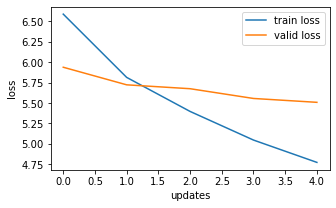

In [53]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [54]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.625 | Test PPL: 277.407 |


In [55]:
model

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(6760, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(7258, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=7258, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

#### Multiplicative Attention
We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [56]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [57]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim, variants='multiplicative')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(6760, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(7258, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=7258, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [58]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

1730560
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
1858048
1966080
786432
  1536
  1536
13006336
  7258
______
23035994


Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [59]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

In [60]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [61]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [62]:
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'multiplicative_model.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 1m 54s
	Train Loss: 6.574 | Train PPL: 716.347
	 Val. Loss: 5.976 |  Val. PPL: 393.964
Epoch: 02 | Time: 1m 55s
	Train Loss: 5.822 | Train PPL: 337.803
	 Val. Loss: 5.738 |  Val. PPL: 310.324
Epoch: 03 | Time: 1m 57s
	Train Loss: 5.470 | Train PPL: 237.482
	 Val. Loss: 5.605 |  Val. PPL: 271.765
Epoch: 04 | Time: 1m 54s
	Train Loss: 5.148 | Train PPL: 172.037
	 Val. Loss: 5.524 |  Val. PPL: 250.643
Epoch: 05 | Time: 1m 55s
	Train Loss: 4.835 | Train PPL: 125.880
	 Val. Loss: 5.581 |  Val. PPL: 265.308


Text(0, 0.5, 'loss')

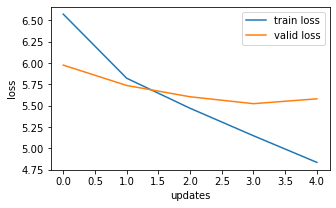

In [63]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [64]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.603 | Test PPL: 271.195 |


In [65]:
model

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(6760, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(7258, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=7258, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

#### Addictive Attention - I will go to the next ipynb due to running out of CUDA's memory
We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [66]:
# input_dim   = len(vocab_transform[SRC_LANGUAGE])
# output_dim  = len(vocab_transform[TRG_LANGUAGE])
# emb_dim     = 256  
# hid_dim     = 512  
# dropout     = 0.5
# SRC_PAD_IDX = PAD_IDX

# attn = Attention(hid_dim, variants='additive')
# enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
# dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

# model = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
# model.apply(initialize_weights)

In [67]:
# we can print the complexity by the number of parameters
# def count_parameters(model):
#     params = [p.numel() for p in model.parameters() if p.requires_grad]
#     for item in params:
#         print(f'{item:>6}')
#     print(f'______\n{sum(params):>6}')
    
# count_parameters(model)

In [68]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

In [69]:
# def train(model, loader, optimizer, criterion, clip, loader_length):
    
#     model.train()
#     epoch_loss = 0
    
#     for src, src_length, trg in loader:
        
#         src = src.to(device)
#         trg = trg.to(device)
        
#         optimizer.zero_grad()
        
#         output, attentions = model(src, src_length, trg)
        
#         #trg    = [trg len, batch size]
#         #output = [trg len, batch size, output dim]
#         output_dim = output.shape[-1]
        
#         #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
#         output = output[1:].view(-1, output_dim)
#         trg    = trg[1:].view(-1)
#         #trg    = [(trg len - 1) * batch size]
#         #output = [(trg len - 1) * batch size, output dim]
        
#         loss = criterion(output, trg)
        
#         loss.backward()
        
#         #clip the gradients to prevent them from exploding (a common issue in RNNs)
#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
#         optimizer.step()
        
#         epoch_loss += loss.item()
        
#     return epoch_loss / loader_length

In [70]:
# def evaluate(model, loader, criterion, loader_length):
        
#     #turn off dropout (and batch norm if used)
#     model.eval()
    
#     epoch_loss = 0
    
#     with torch.no_grad():
    
#         for src, src_length, trg in loader:
        
#             src = src.to(device)
#             trg = trg.to(device)

#             output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

#             #trg    = [trg len, batch size]
#             #output = [trg len, batch size, output dim]

#             output_dim = output.shape[-1]
            
#             output = output[1:].view(-1, output_dim)
#             trg = trg[1:].view(-1)

#             #trg    = [(trg len - 1) * batch size]
#             #output = [(trg len - 1) * batch size, output dim]

#             loss = criterion(output, trg)
            
#             epoch_loss += loss.item()
        
#     return epoch_loss / loader_length

In [71]:
# best_valid_loss = float('inf')
# num_epochs = 5
# clip       = 1

# save_path = f'additive_model.pt'

# train_losses = []
# valid_losses = []

# for epoch in range(num_epochs):
    
#     start_time = time.time()

#     train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
#     valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
#     #for plotting
#     train_losses.append(train_loss)
#     valid_losses.append(valid_loss)
    
#     end_time = time.time()
    
#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), save_path)
    
#     print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
#     #lower perplexity is better

In [72]:
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(5, 3))
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(train_losses, label = 'train loss')
# ax.plot(valid_losses, label = 'valid loss')
# plt.legend()
# ax.set_xlabel('updates')
# ax.set_ylabel('loss')

In [73]:
# model.load_state_dict(torch.load(save_path))
# test_loss = evaluate(model, test_loader, criterion, test_loader_length)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

In [74]:
# model

### 6* Comparison

#### To conclude, the multiplicative one is a litte bit better than the gerenal one in term of lower perplexity (271 < 277) and the calculating time (1s55 < 1s57)

## 7. Test on some random

In [75]:
dataset[0][0]

'Of this land mass, roughly 18% is arable.'

In [76]:
dataset[0][1]

'Le secteur de la transformation des aliments de la Tunisie est également crucial à l’économie du pays.'

In [77]:
src_text = text_transform[SRC_LANGUAGE](dataset[0][0]).to(device)
src_text

tensor([   2, 2499,    4,  584,  231,    4, 1023,    7,    4,  619,    4,  822,
          33,    4,   13,    4, 2555,    6,    3], device='cuda:2')

In [78]:
trg_text = text_transform[TRG_LANGUAGE](dataset[0][1]).to(device)
trg_text

tensor([  2,  37,  65,   4,   8, 753,  10, 112,   4,   8, 185,  21,  99,   0,
         12, 616,  16,  47,   6,   3], device='cuda:2')

In [79]:
src_text = src_text.reshape(-1, 1)  #because batch_size is 1

In [80]:
trg_text = trg_text.reshape(-1, 1)

In [81]:
src_text.shape, trg_text.shape

(torch.Size([19, 1]), torch.Size([20, 1]))

In [82]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [83]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, text_length, trg_text, 0) #turn off teacher forcing

In [84]:
output.shape #trg_len, batch_size, trg_output_dim

torch.Size([20, 1, 7258])

Since batch size is 1, we just take off that dimension

In [85]:
output = output.squeeze(1)

In [86]:
output.shape

torch.Size([20, 7258])

We shall remove the first token since it's zeroes anyway

In [87]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([19, 7258])

Then we just take the top token with highest probabilities

In [88]:
output_max = output.argmax(1) #returns max indices

In [89]:
output_max

tensor([33,  0,  4,  8, 42,  4,  8, 42,  4,  8, 42,  4,  8,  6,  3,  3,  6,  3,
         6], device='cuda:2')

Get the mapping of the target language

In [90]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [91]:
for token in output_max:
    print(mapping[token.item()])

Les
<unk>
de
la
%
de
la
%
de
la
%
de
la
.
<eos>
<eos>
.
<eos>
.
